# 3a) Baseline Search & Metrics

In this notebook we create a query set and run a `best_match` query with a reasonable set of search fields and weights.

In addition to the ESCI product data we are making use of the judgements that we map to numeric values.

For each query we calculate search metrics and an average over all queries.

This gives us a baseline that we can use as our foundation when exploring different hybrid search configurations in the next notebook.

In [1]:
import pandas as pd
import numpy as np
import mercury as mr
import requests
import json
import plotly.express as px
import plotly.io as pio
from opensearchpy import OpenSearch

In [2]:
DATA_DIR = '/Users/danielwrigley/work/Testing/git_repos/esci-data/shopping_queries_dataset/'

In [3]:
df_examples = pd.read_parquet(DATA_DIR + '/shopping_queries_dataset_examples.parquet')

## Query set
A query set has the columns:

* `query_set_id`
* `query`

There is currently no date corresponding to the query set. And currently the sampling is not done based on frequency.

In [4]:
# We only use English queries for now
df_queries_us = df_examples[df_examples['product_locale'] == 'us']

In [5]:
np.random.seed(10)

In [6]:
# Sample query sets
# In the file most_judged.csv are the queries with most judgements in the ESCI dataset.
# Use it by setting b_most_judged = True to have metrics calculations based on minimal missing judgements.
b_most_judged = False

query_sets = [("sampled_queries", 200), ("top_queries", 20)]

res = []

if b_most_judged:
    df_query_set = pd.read_csv('most_judged.csv')
else:
    for query_set_id, n_query_set in query_sets:
        # todo: sampling proportional to frequency
        query_set = np.random.choice(df_queries_us["query"].unique(), n_query_set, replace=False)
    
        df = pd.DataFrame({"query": query_set})
        df["query_set_id"] = query_set_id
        res.append(df)
    df_query_set = pd.concat(res)
df_query_set.head(10)

,query,query_set_id
0,runtz,sampled_queries
1,trooper bandana shoe,sampled_queries
2,tcl a1x phone case straight talk,sampled_queries
3,bose headphones replacement cord,sampled_queries
4,uniball vision elite,sampled_queries
5,definitely not paid enough for this,sampled_queries
6,raid deep reach fogger,sampled_queries
7,usb camera,sampled_queries
8,reusable produce bags,sampled_queries
9,latex dental dam,sampled_queries


## Judgments
The judgments dataset has a row per query instance and document and has the following columns:

* datetime: date of query/document instance
* query_id: identifier of query instance
* query: the query
* document: identifier of a document result
* judgment: Here we use the proposed ESCI mapping for DCG: `{"E": 0, "S": 1, "C": 2, "I": 3}` --> this looks odd. These look more like labels since `E` means "Exact Match" and would be the lowest score according to that wording

In [7]:
# Select judgments
# Map esci_label to score
# create judgments per day in range
# create noise in score

label_num = {"E": 0, "S": 1, "C": 2, "I": 3}
label_score = [3, 2, 1, 0]
#label_score = [1, 0.1, 0.01, 0]

def label_to_score(label):
    return label_score[label_num[label]]

df_judge = df_examples[df_examples["query"].isin(set(df_query_set["query"].values))].copy()
df_judge["judgment"] = df_judge.esci_label.apply(lambda x: label_to_score(x))
df_judge["document"] = df_judge.product_id
df_judge = df_judge[["query", "document", "judgment"]].reset_index(drop=True)
df_judge.head(3)

,query,document,judgment
0,$30 roblox gift card not digital,B07RX6FBFR,3
1,$30 roblox gift card not digital,B09194H44R,0
2,$30 roblox gift card not digital,B08R5N6W6B,2


# Transform the queries and judgments

### Group by queries and export to a file with the index to have queries and query ids

In [8]:
df_queries = df_judge.groupby(by='query', as_index=False).agg({
    'judgment': ['count']
})
df_query_idx = df_queries['query']
# save the generated query set if the most judged queries are not used
if not b_most_judged:
    name = 'queries.txt'
    df_query_idx.to_csv(name, sep="\t", header=False)

In [9]:
df_queries

,query,judgment
,,count
0,$30 roblox gift card not digital,15
1,(fiction without frontiers),16
2,100,16
3,10x10x6 cake box without window,16
4,15 inch light weight laptop that has lots of m...,15
...,...,...
215,wooden stool,16
216,woodwick wax melt,16
217,world of warcraft anniversary collector's edition,16


### Go through the queries and update the original ratings with the query ids

In [10]:
df_query_idx = pd.DataFrame(df_query_idx)

In [11]:
df_query_idx = df_query_idx.reset_index().rename(columns={'index': 'idx'})

df_merged = pd.merge(df_judge, df_query_idx, on='query', how='left')
df_merged.columns = ['query', 'docid', 'rating', 'idx']

In [12]:
df_merged

,query,docid,rating,idx
0,$30 roblox gift card not digital,B07RX6FBFR,3,0
1,$30 roblox gift card not digital,B09194H44R,0,0
2,$30 roblox gift card not digital,B08R5N6W6B,2,0
3,$30 roblox gift card not digital,B07Y693ND1,0,0
4,$30 roblox gift card not digital,B07RZ75JW3,2,0
...,...,...,...,...
4060,yarn purple and pink,B00JX10Q2O,2,219
4061,yarn purple and pink,B00KY41UHO,3,219
4062,yarn purple and pink,B00QXJOUL2,3,219
4063,yarn purple and pink,B00UY14WCM,3,219


In [13]:
name = 'ratings.csv'

df_merged.to_csv(name, sep="\t", header=False, index=False)
df_merged.head(3)

,query,docid,rating,idx
0,$30 roblox gift card not digital,B07RX6FBFR,3,0
1,$30 roblox gift card not digital,B09194H44R,0,0
2,$30 roblox gift card not digital,B08R5N6W6B,2,0


## Query OpenSearch with the Baseline Configuration

We use a simple `multi_match` query with a couple of fields and field weights.

This will serve as our baseline. We get the first 10 results for each query we have in `df_judge` and store the results in a format that `trec_eval`can work with later when evaluating the results.

This gives us a quantification of the quality of the baseline configuration.

We will use this to compare our hybrid search configurations against.

In [14]:
url = "http://localhost:9200/ecommerce/_search"

headers = {
    'Content-Type': 'application/json'
}

df_relevance = pd.DataFrame()

for query in df_query_idx.itertuples():

    payload = {
      "_source": {
        "excludes": [
          "title_embedding"
        ]
      },
      "query": {
        "multi_match" : {
          "type":       "best_fields",
          "fields":     [
              "product_id^100",
            "product_bullet_point^3",
            "product_color^2",
            "product_brand^5",
            "product_description",
            "product_title^10"
          ],
          "operator":   "and",
          "query":      query[2]
        }
      }
    }

    response = requests.request("POST", url, headers=headers, data=json.dumps(payload)).json()
    
    position = 0
    num_results = response['hits']['total']['value']
    for hit in response['hits']['hits']:
        # create a new row for the DataFrame and append it
        row = { 'query_id' : str(query[1]), 'query_string': query[2], 'product_id' : hit["_id"], 'position' : position, 'num_results' : num_results, 'relevance' : hit["_score"], 'run': 'default' }
    
        new_row_df = pd.DataFrame([row])
        df_relevance = pd.concat([df_relevance, new_row_df], ignore_index=True)
        position += 1
    
# work with two for loops:
# 1) one to iterate over the list of queries and have a query id instead of a query
# 2) another one to iterate over the result sets to have the position of the result in the result set 

# DataFrame with columns:
# query_id: the id of the query as the trec_eval tool needs a numeric id rather than a query string as an identifier
# product_id: the id of the product in the hit list
# position: the position of the product in the result set
# relevance: relevance as given by the search engine
# run: the name of the query run

In [15]:
name = 'baseline_results'
df_relevance.to_csv(name, sep="\t", header=False, index=False)

In [16]:
df_relevance.head(3)

,query_id,query_string,product_id,position,num_results,relevance,run
0,1,(fiction without frontiers),1787581780,0,42,309.1219,default
1,1,(fiction without frontiers),B082VGLV18,1,42,309.1219,default
2,1,(fiction without frontiers),B07GJVWWWR,2,42,309.1219,default


In [17]:
df_merged.head(3)

,query,docid,rating,idx
0,$30 roblox gift card not digital,B07RX6FBFR,3,0
1,$30 roblox gift card not digital,B09194H44R,0,0
2,$30 roblox gift card not digital,B08R5N6W6B,2,0


In [18]:
# Make sure ids are strings - otherwise the merge operation might cause an error
df_relevance['query_id'] = df_relevance['query_id'].astype(str)
df_merged['idx'] = df_merged['idx'].astype(str)
# Remove duplicates from the ratings DataFrame
df_unique_ratings = df_merged.drop_duplicates(subset=['docid', 'idx'])

In [19]:
# Merge results on query_id and product_id so that the resulting DataFrame has the ratings together with the search results
df_merged = df_relevance.merge(df_unique_ratings, left_on=['query_id', 'product_id'], right_on=['idx', 'docid'], how='left', validate='one_to_one')
df_merged = df_merged.drop(columns=['query', 'docid', 'idx'])

df_merged.head(10)

,query_id,query_string,product_id,position,num_results,relevance,run,rating
0,1,(fiction without frontiers),1787581780,0,42,309.12190,default,NaN
1,1,(fiction without frontiers),B082VGLV18,1,42,309.12190,default,NaN
2,1,(fiction without frontiers),B07GJVWWWR,2,42,309.12190,default,3.0
3,1,(fiction without frontiers),B08C5MQFCY,3,42,309.12190,default,3.0
4,1,(fiction without frontiers),1787583325,4,42,298.64386,default,NaN
5,1,(fiction without frontiers),B07KL6QTN1,5,42,298.64386,default,NaN
6,1,(fiction without frontiers),B07QCVBDRS,6,42,298.64386,default,NaN
7,1,(fiction without frontiers),B07SM9NJCP,7,42,298.64386,default,NaN
8,1,(fiction without frontiers),B07RG5TT93,8,42,298.64386,default,NaN
9,1,(fiction without frontiers),B07L9JSMT8,9,42,298.64386,default,3.0


In [20]:
# Count the rows without ratings - the higher the count is the less reliable the results will be
nan_count_rating = df_merged['rating'].isna().sum()
print(f"There are {df_merged.shape[0]} rows and {nan_count_rating} do not contain a rating")

There are 1619 rows and 995 do not contain a rating


## Metrics

In [21]:
def dcg_at_10(df):
    # Sort DataFrame by position and take the top 10 results
    df = df.head(10)
    
    # Apply DCG formula
    dcg = np.sum((df['rating']) / np.log2(df['position'] + 2))
    
    return dcg

def ndcg_at_10(df):
    # Sort DataFrame by position and take the top 10 results
    top_10 = df.sort_values('position').head(10)
    
    # Calculate DCG@10
    dcg = dcg_at_10(top_10)
    
    # Sort by rating in descending order to get the ideal DCG
    ideal_top_10 = df.sort_values('rating', ascending=False).head(10)
    
    # Reset the positional information - otherwise it uses the original positions and the 
    # changed sorting would have no effect
    ideal_top_10['position'] = range(ideal_top_10.shape[0])
    
    # Calculate iDCG (ideal DCG)
    idcg = np.sum((ideal_top_10['rating']) / np.log2(ideal_top_10['position'] + 2))
    
    # Handle cases where iDCG is 0
    if idcg == 0:
        return 0
    
    # Normalize DCG
    ndcg = dcg / idcg
    
    return ndcg

def precision_at_k(df, k=10):
    # Sort by position and take the top k results
    top_k = df.sort_values('position').head(k)
    
    # Calculate the number of relevant results (assuming relevance > 1 is relevant)
    relevant_count = np.sum(top_k['rating'] > 1)
    
    # Calculate precision
    precision = relevant_count / k
    
    return precision

def ratio_of_ratings(df, k=10, **kwargs):
    top_k = df.sort_values('position').head(k)
    num_of_ratings = top_k[~top_k['rating'].isna()].shape[0]
    num_of_shown_results = top_k.shape[0]
    if num_of_shown_results == 0:
        return 0
    else:
        return num_of_ratings/num_of_shown_results

metrics = [
    ("dcg", dcg_at_10, None),
    ("ndcg", ndcg_at_10, None),
    ("prec@10", lambda x: precision_at_k(x, 10), None),
    ("ratio_of_ratings", lambda x: ratio_of_ratings(x), None)
]

## Calculate Metrics

Iterate over the queries in the query set, calculate the three metrics dcg@10, ndcg@10 and precision@10 and store the results for every query in a DataFrame

In [22]:
df_metrics = []
for m_name, m_function, ref_search in metrics:
    for query in df_query_idx.itertuples():
        metric = m_function(df_merged[df_merged['query_string'] == query[2]])
        df_metrics.append(pd.DataFrame({
            "query": [query[2]],
            "metric": [m_name],
            "value": [metric],
        }))
df_metrics = pd.concat(df_metrics)

In [23]:
df_metrics

,query,metric,value
0,$30 roblox gift card not digital,dcg,0.000000
0,(fiction without frontiers),dcg,3.659224
0,100,dcg,0.000000
0,10x10x6 cake box without window,dcg,0.000000
0,15 inch light weight laptop that has lots of m...,dcg,0.000000
...,...,...,...
0,wooden stool,ratio_of_ratings,0.000000
0,woodwick wax melt,ratio_of_ratings,1.000000
0,world of warcraft anniversary collector's edition,ratio_of_ratings,1.000000
0,wowled,ratio_of_ratings,1.000000


In [24]:
# Use query (fiction without frontiers) for random query set, and 3 ring binder for most judged query set
df_metrics[df_metrics['query'] == '(fiction without frontiers)']
#df_metrics[df_metrics['query'] == '3 ring binder']

,query,metric,value
0,(fiction without frontiers),dcg,3.659224
0,(fiction without frontiers),ndcg,0.572399
0,(fiction without frontiers),prec@10,0.300000
0,(fiction without frontiers),ratio_of_ratings,0.300000


In [25]:
print(f"Average DCG: {df_metrics[df_metrics['metric'] == 'dcg']['value'].mean().round(2)}")
print(f"Average NDCG: {df_metrics[df_metrics['metric'] == 'ndcg']['value'].mean().round(2)}")
print(f"Average Precision: {df_metrics[df_metrics['metric'] == 'prec@10']['value'].mean().round(2)}")

Average DCG: 4.1
Average NDCG: 0.54
Average Precision: 0.27


In [26]:
df_metrics.reset_index(drop=True, inplace=True)

In [27]:
df_metrics

,query,metric,value
0,$30 roblox gift card not digital,dcg,0.000000
1,(fiction without frontiers),dcg,3.659224
2,100,dcg,0.000000
3,10x10x6 cake box without window,dcg,0.000000
4,15 inch light weight laptop that has lots of m...,dcg,0.000000
...,...,...,...
875,wooden stool,ratio_of_ratings,0.000000
876,woodwick wax melt,ratio_of_ratings,1.000000
877,world of warcraft anniversary collector's edition,ratio_of_ratings,1.000000
878,wowled,ratio_of_ratings,1.000000


In [28]:
df_pivot = df_metrics.pivot(index='query', columns='metric', values='value').reset_index()

In [29]:
df_pivot

metric,query,dcg,ndcg,prec@10,ratio_of_ratings
0,$30 roblox gift card not digital,0.000000,0.000000,0.0,0.0
1,(fiction without frontiers),3.659224,0.572399,0.3,0.3
2,100,0.000000,0.000000,0.0,0.0
3,10x10x6 cake box without window,0.000000,0.000000,0.0,0.0
4,15 inch light weight laptop that has lots of m...,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...
215,wooden stool,0.000000,0.000000,0.0,0.0
216,woodwick wax melt,13.630678,1.000000,1.0,1.0
217,world of warcraft anniversary collector's edition,3.000000,1.000000,0.1,1.0
218,wowled,11.860394,1.000000,0.8,1.0


In [30]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

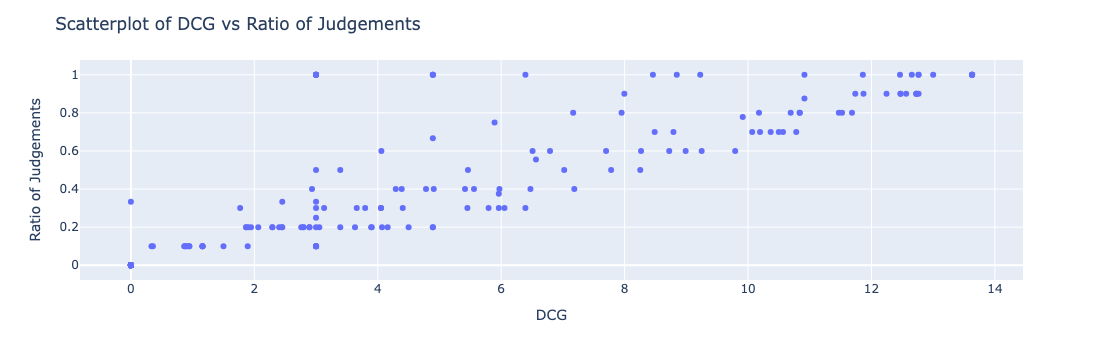

In [31]:
pio.renderers.default = 'plotly_mimetype'
fig = px.scatter(df_pivot, 
                 x='dcg', y='ratio_of_ratings', 
                 hover_data={'query': True},  # Show query on hover
                 labels={'dcg': 'DCG', 'ratio_of_ratings': 'Ratio of Judgements'})

# Customize the layout
fig.update_layout(title="Scatterplot of DCG vs Ratio of Judgements",
                  xaxis_title="DCG",
                  yaxis_title="Ratio of Judgements",
                  hovermode="closest")

# Show the plot
fig.show()